# Analysis after Peak-calling with MACS2

In [24]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [86]:
def readBroadPeak(file, qthreshold=0.01, lenthreshold=250):
    data = pd.read_csv(file, sep='\t', header=None, 
            names = ['Chrom', 'start', 'end', 'name', 'score', '.', 'fc', 'neglogp', 'neglogq'])
    data['len'] = abs(data['start'] - data['end'])
    export_data = data[(data.neglogq >= (-1)*np.log10(qthreshold)) & (data.len >= lenthreshold)]
    export_data = export_data.drop(columns=['len'])
    return export_data

In [88]:
IRI1A = readBroadPeak('./IRI1A_peaks.broadPeak')
IRI2A = readBroadPeak('./IRI2A_peaks.broadPeak')
SHAM1A = readBroadPeak('./Sham1A_peaks.broadPeak')
SHAM2A =  readBroadPeak('./Sham2A_peaks.broadPeak')

In [89]:
IRI1A.to_csv("./IRI1A_peaks.q.01.len250.broadPeak", header=False, sep='\t', index=False)
IRI2A.to_csv("./IRI2A_peaks.q.01.len250.broadPeak", header=False, sep='\t', index=False)
SHAM1A.to_csv("./SHAM1A_peaks.q.01.len250.broadPeak", header=False, sep='\t', index=False)
SHAM2A.to_csv("./SHAM2A_peaks.q.01.len250.broadPeak", header=False, sep='\t', index=False)

In [90]:
IRI1A.describe()

,start,end,score,fc,neglogp,neglogq
count,8.290200e+04,8.290200e+04,82902.000000,82902.000000,82902.000000,82902.000000
mean,7.474784e+07,7.474873e+07,165.733300,4.345791,18.603464,16.623200
std,4.395640e+07,4.395640e+07,225.955258,1.736312,22.839966,22.595563
min,8.085650e+05,8.102000e+05,20.000000,1.586580,3.482290,2.000030
25%,3.688139e+07,3.688208e+07,39.000000,3.028540,5.757837,3.972822
50%,7.251729e+07,7.251784e+07,80.000000,3.824855,9.972725,8.065150
75%,1.075940e+08,1.075951e+08,191.000000,5.201398,21.297007,19.195873
max,1.952320e+08,1.952331e+08,2950.000000,17.592900,298.922850,295.039490


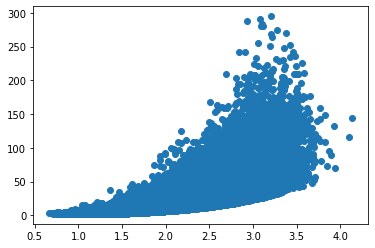

In [91]:
plt.scatter(np.log2(IRI1A.fc), IRI1A.neglogq)

In [40]:
import rpy2.ipython
%reload_ext rpy2.ipython

# suppress excessive warnings such as RRuntimeWarning
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)

## Calling consensus peaks in Bioconductor

- Ref : https://ro-che.info/articles/2018-07-11-chip-seq-consensus

In [61]:
%%R
library(UpSetR)
library(rtracklayer)
library(GenomicRanges)

## Getting total union peak set [No filter]

In [65]:
%%R
macs2_peak_files_unfiltered.files <- list.files(pattern =".*\\peaks.broadPeak")
macs2_peak_files_unfiltered.files

[1] "IRI1A_peaks.broadPeak"  "IRI2A_peaks.broadPeak"  "Sham1A_peaks.broadPeak"
[4] "Sham2A_peaks.broadPeak"


In [66]:
%%R
macs2_peak_files_unfiltered.granges <- lapply(macs2_peak_files_unfiltered.files, import)
macs2_peak_files_unfiltered.granges

[[1]]
GRanges object with 240761 ranges and 5 metadata columns:
           seqnames            ranges strand |              name     score
              <Rle>         <IRanges>  <Rle> |       <character> <numeric>
       [1]     chr1   3012435-3012743      * |      IRI1A_peak_1         0
       [2]     chr1   3014527-3015640      * |      IRI1A_peak_2         0
       [3]     chr1   3019513-3019738      * |      IRI1A_peak_3         0
       [4]     chr1   3026870-3027493      * |      IRI1A_peak_4         0
       [5]     chr1   3039077-3039284      * |      IRI1A_peak_5         3
       ...      ...               ...    ... .               ...       ...
  [240757]     chrY   9881596-9881797      * | IRI1A_peak_240757         0
  [240758]     chrY 10043114-10043337      * | IRI1A_peak_240758         0
  [240759]     chrY 10512796-10513008      * | IRI1A_peak_240759         1
  [240760]     chrY 41123356-41123789      * | IRI1A_peak_240760         0
  [240761]     chrY 41153398-4115357

In [67]:
%%R
macs2_peak_files_unfiltered.grangeslist <- GRangesList(macs2_peak_files_unfiltered.granges)
macs2_peak_files_unfiltered.grangeslist

GRangesList object of length 4:
[[1]] 
GRanges object with 240761 ranges and 5 metadata columns:
           seqnames            ranges strand |              name     score
              <Rle>         <IRanges>  <Rle> |       <character> <numeric>
       [1]     chr1   3012435-3012743      * |      IRI1A_peak_1         0
       [2]     chr1   3014527-3015640      * |      IRI1A_peak_2         0
       [3]     chr1   3019513-3019738      * |      IRI1A_peak_3         0
       [4]     chr1   3026870-3027493      * |      IRI1A_peak_4         0
       [5]     chr1   3039077-3039284      * |      IRI1A_peak_5         3
       ...      ...               ...    ... .               ...       ...
  [240757]     chrY   9881596-9881797      * | IRI1A_peak_240757         0
  [240758]     chrY 10043114-10043337      * | IRI1A_peak_240758         0
  [240759]     chrY 10512796-10513008      * | IRI1A_peak_240759         1
  [240760]     chrY 41123356-41123789      * | IRI1A_peak_240760         0
  [

In [68]:
%%R
macs2_peak_files_unfiltered.coverage <- coverage(macs2_peak_files_unfiltered.grangeslist)
macs2_peak_files_unfiltered.coverage

RleList of length 21
$chr1
integer-Rle of length 195309171 with 149926 runs
  Lengths: 3003426     444    8564      63 ...      20     187      83      10
  Values :       0       1       0       1 ...       1       3       2       1

$chr10
integer-Rle of length 130542265 with 96465 runs
  Lengths: 3170106     190    2598     164 ...     605       1      34       4
  Values :       0       1       0       1 ...       4       3       2       1

$chr11
integer-Rle of length 121977616 with 82210 runs
  Lengths: 3201954     115       7       1 ...    9015     290   11267     190
  Values :       0       1       2       3 ...       0       1       0       1

$chr12
integer-Rle of length 120002754 with 84471 runs
  Lengths: 3098110      26       3      15 ...     271     184    9280     193
  Values :       0       1       2       3 ...       2       1       0       1

$chr13
integer-Rle of length 120313820 with 80142 runs
  Lengths: 3045440     177     212      12 ...    1917     261    87

In [77]:
%%R
# slice function : https://support.bioconductor.org/p/83326/
# https://www.rdocumentation.org/packages/IRanges/versions/2.6.1/topics/slice-methods
# lower : the regions in the genome where coverage is at least 2
macs2_peak_files_unfiltered.covered_ranges <- slice(macs2_peak_files_unfiltered.coverage, lower=1, rangesOnly=T)
macs2_peak_files_unfiltered.covered_ranges <- GRanges(macs2_peak_files_unfiltered.covered_ranges)
macs2_peak_files_unfiltered.covered_ranges

GRanges object with 374668 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]     chr1   3003427-3003870      *
       [2]     chr1   3012435-3012785      *
       [3]     chr1   3014527-3015640      *
       [4]     chr1   3019513-3019738      *
       [5]     chr1   3026870-3027493      *
       ...      ...               ...    ...
  [374664]     chrY 10561059-10561294      *
  [374665]     chrY 41089491-41089671      *
  [374666]     chrY 41122766-41123933      *
  [374667]     chrY 41153012-41153221      *
  [374668]     chrY 41153398-41153576      *
  -------
  seqinfo: 21 sequences from an unspecified genome; no seqlengths


#### Total Union peak : 374,668 peaks

In [79]:
%%R
# reduce function: reduce returns an object of the same type as x containing reduced ranges for each distinct
# (seqname, strand) pairing. The names (names(x)) and the metadata columns in x are dropped.
# See ?reduce for more information about range reduction and for a description of the optional arguments.
# More : https://www.rdocumentation.org/packages/GenomicRanges/versions/1.24.1/topics/inter-range-methods
macs2_peak_files_unfiltered.merged_covered_ranges <- reduce(macs2_peak_files_unfiltered.covered_ranges, 
                                                            min.gapwidth=500)

macs2_peak_files_unfiltered.merged_covered_ranges

GRanges object with 357013 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]     chr1   3003427-3003870      *
       [2]     chr1   3012435-3012785      *
       [3]     chr1   3014527-3015640      *
       [4]     chr1   3019513-3019738      *
       [5]     chr1   3026870-3028381      *
       ...      ...               ...    ...
  [357009]     chrY 10512787-10513033      *
  [357010]     chrY 10561059-10561294      *
  [357011]     chrY 41089491-41089671      *
  [357012]     chrY 41122766-41123933      *
  [357013]     chrY 41153012-41153576      *
  -------
  seqinfo: 21 sequences from an unspecified genome; no seqlengths


#### Merged Union peaks (nearby threshold 500bp) : 357,013

In [80]:
%%R
export(macs2_peak_files_unfiltered.merged_covered_ranges, "post_macs2_peak-calling_consensus.noFilter.UNION.broadPeak.bed")

## Getting total union peak set [Filter FDR <= 0.01, len >= 250]

In [93]:
%%R
macs2_peak_files_filtered.files <- list.files(pattern =".*\\q.01.len250.broadPeak")
macs2_peak_files_filtered.granges <- lapply(macs2_peak_files_filtered.files, import)
macs2_peak_files_filtered.grangeslist <- GRangesList(macs2_peak_files_filtered.granges)
macs2_peak_files_filtered.coverage <- coverage(macs2_peak_files_filtered.grangeslist)
macs2_peak_files_filtered.covered_ranges <- slice(macs2_peak_files_filtered.coverage, lower=1, rangesOnly=T)
macs2_peak_files_filtered.covered_ranges <- GRanges(macs2_peak_files_filtered.covered_ranges)
macs2_peak_files_filtered.covered_ranges

GRanges object with 107460 ranges and 0 metadata columns:
           seqnames          ranges strand
              <Rle>       <IRanges>  <Rle>
       [1]     chr1 3116593-3117640      *
       [2]     chr1 3119338-3121591      *
       [3]     chr1 3126063-3126476      *
       [4]     chr1 3154842-3157891      *
       [5]     chr1 3176551-3176879      *
       ...      ...             ...    ...
  [107456]     chrY 1254838-1255276      *
  [107457]     chrY 2308813-2309456      *
  [107458]     chrY 5670911-5671236      *
  [107459]     chrY 5920093-5920381      *
  [107460]     chrY 9389661-9390192      *
  -------
  seqinfo: 21 sequences from an unspecified genome; no seqlengths


In [122]:
%%R
print(mcols(macs2_peak_files_filtered.covered_ranges))

DataFrame with 107460 rows and 0 columns


#### Total Union peak : 107,460 peaks

In [94]:
%%R
macs2_peak_files_filtered.merged_covered_ranges <- reduce(macs2_peak_files_filtered.covered_ranges, 
                                                            min.gapwidth=500)
macs2_peak_files_filtered.merged_covered_ranges

GRanges object with 107371 ranges and 0 metadata columns:
           seqnames          ranges strand
              <Rle>       <IRanges>  <Rle>
       [1]     chr1 3116593-3117640      *
       [2]     chr1 3119338-3121591      *
       [3]     chr1 3126063-3126476      *
       [4]     chr1 3154842-3157891      *
       [5]     chr1 3176551-3176879      *
       ...      ...             ...    ...
  [107367]     chrY 1254838-1255276      *
  [107368]     chrY 2308813-2309456      *
  [107369]     chrY 5670911-5671236      *
  [107370]     chrY 5920093-5920381      *
  [107371]     chrY 9389661-9390192      *
  -------
  seqinfo: 21 sequences from an unspecified genome; no seqlengths


In [123]:
%%R
print(mcols(macs2_peak_files_filtered.merged_covered_ranges))

DataFrame with 107371 rows and 0 columns


#### Merged Union peaks (nearby threshold 500bp) : 107,371

In [95]:
%%R
export(macs2_peak_files_filtered.merged_covered_ranges,
       "post_macs2_peak-calling_consensus.q.01.len250.UNION.broadPeak.bed")

### Individual files

In [127]:
%%R
merge_covered_range <- function(pattern=".*\\q.01.len250.broadPeak") {   
    macs2_peak_files_filtered.files <- list.files(pattern=pattern)
    macs2_peak_files_filtered.granges <- lapply(macs2_peak_files_filtered.files, import)
    macs2_peak_files_filtered.grangeslist <- GRangesList(macs2_peak_files_filtered.granges)
    macs2_peak_files_filtered.coverage <- coverage(macs2_peak_files_filtered.grangeslist)
    macs2_peak_files_filtered.covered_ranges <- slice(macs2_peak_files_filtered.coverage, lower=1, rangesOnly=T)
    macs2_peak_files_filtered.covered_ranges <- GRanges(macs2_peak_files_filtered.covered_ranges)
    macs2_peak_files_filtered.covered_ranges
    print(mcols(macs2_peak_files_filtered.covered_ranges))
    macs2_peak_files_filtered.merged_covered_ranges <- reduce(macs2_peak_files_filtered.covered_ranges, 
                                                            min.gapwidth=500)
    print(mcols(macs2_peak_files_filtered.merged_covered_ranges))
   return(macs2_peak_files_filtered.merged_covered_ranges)   
 }

IRI1A

In [129]:
%%R
merge_covered_range(pattern="IRI1A_peaks.q.01.len250.broadPeak")

DataFrame with 82902 rows and 0 columns
DataFrame with 82902 rows and 0 columns
GRanges object with 82902 ranges and 0 metadata columns:
          seqnames          ranges strand
             <Rle>       <IRanges>  <Rle>
      [1]     chr1 3119639-3120688      *
      [2]     chr1 3248952-3249591      *
      [3]     chr1 3346784-3350416      *
      [4]     chr1 3372578-3373177      *
      [5]     chr1 3399855-3401447      *
      ...      ...             ...    ...
  [82898]     chrY 1009981-1010813      *
  [82899]     chrY 1178532-1178922      *
  [82900]     chrY 1212311-1212621      *
  [82901]     chrY 1244877-1246086      *
  [82902]     chrY 5920093-5920381      *
  -------
  seqinfo: 21 sequences from an unspecified genome; no seqlengths


IRI2A

In [130]:
%%R
merge_covered_range(pattern="IRI2A_peaks.q.01.len250.broadPeak")

DataFrame with 81982 rows and 0 columns
DataFrame with 81982 rows and 0 columns
GRanges object with 81982 ranges and 0 metadata columns:
          seqnames          ranges strand
             <Rle>       <IRanges>  <Rle>
      [1]     chr1 3119611-3121591      *
      [2]     chr1 3248840-3249563      *
      [3]     chr1 3349863-3350345      *
      [4]     chr1 3372589-3373160      *
      [5]     chr1 3399825-3401532      *
      ...      ...             ...    ...
  [81978]     chrY 1009997-1010824      *
  [81979]     chrY 1066936-1067213      *
  [81980]     chrY 1178532-1178929      *
  [81981]     chrY 1212334-1212585      *
  [81982]     chrY 1244692-1246098      *
  -------
  seqinfo: 21 sequences from an unspecified genome; no seqlengths


SHAM1A

In [131]:
%%R
merge_covered_range(pattern="SHAM1A_peaks.q.01.len250.broadPeak")

DataFrame with 77309 rows and 0 columns
DataFrame with 77309 rows and 0 columns
GRanges object with 77309 ranges and 0 metadata columns:
          seqnames          ranges strand
             <Rle>       <IRanges>  <Rle>
      [1]     chr1 3116796-3117640      *
      [2]     chr1 3119338-3120744      *
      [3]     chr1 3155407-3156015      *
      [4]     chr1 3248813-3251126      *
      [5]     chr1 3349863-3350442      *
      ...      ...             ...    ...
  [77305]     chrY 1244764-1246080      *
  [77306]     chrY 1254838-1255276      *
  [77307]     chrY 2308823-2309168      *
  [77308]     chrY 5670911-5671236      *
  [77309]     chrY 9389697-9390192      *
  -------
  seqinfo: 21 sequences from an unspecified genome; no seqlengths


SHAM2A

In [132]:
%%R
merge_covered_range(pattern="SHAM2A_peaks.q.01.len250.broadPeak")

DataFrame with 81374 rows and 0 columns
DataFrame with 81374 rows and 0 columns
GRanges object with 81374 ranges and 0 metadata columns:
          seqnames          ranges strand
             <Rle>       <IRanges>  <Rle>
      [1]     chr1 3116593-3117536      *
      [2]     chr1 3119604-3120580      *
      [3]     chr1 3126063-3126476      *
      [4]     chr1 3154842-3157891      *
      [5]     chr1 3176551-3176879      *
      ...      ...             ...    ...
  [81370]     chrY 1212157-1212604      *
  [81371]     chrY 1244877-1246082      *
  [81372]     chrY 1254841-1255169      *
  [81373]     chrY 2308813-2309456      *
  [81374]     chrY 9389661-9390019      *
  -------
  seqinfo: 21 sequences from an unspecified genome; no seqlengths


### Using R 3.6 Biocmanger for ChIPQC and soGGi

https://rockefelleruniversity.github.io/RU_ATAC_Workshop.html#greenleaf-dataset---annotating-open-regions.

## Load consensus - intersection data -making bedGraph

In [243]:
%%R
#https://rockefelleruniversity.github.io/RU_ATAC_Workshop.html
macs2_peak_files_filtered.files <- list.files(pattern=".*\\q.01.len250.broadPeak")
macs2_peak_files_filtered.granges <- lapply(macs2_peak_files_filtered.files, import)
names(macs2_peak_files_filtered.granges) <- c("IRI1A", "IRI2A", "SHAM1A", "SHAM2A")
Group <- factor(c("IRI", "IRI", "SHAM", "SHAM"))
macs2_peak_files_filtered.grangeslist <- GRangesList(macs2_peak_files_filtered.granges)

consensusToCount <- soGGi:::runConsensusRegions(macs2_peak_files_filtered.grangeslist, "none")
consensusToCount



In [ ]:
%%R
consensusToCount <- soGGi:::runConsensusRegions(GRangesList(myPeaks), "none")
consensusToCount

In [ ]:
Pythonic way

In [205]:
UNION_bedgraph = pd.read_csv("./post_macs2_peak-calling_consensus.q.01.len250.UNION.bedGraph", sep='\t', header=None)
UNION_bedgraph = UNION_bedgraph[UNION_bedgraph[3] == 1]

In [219]:
IRI1A_bedgraph = pd.read_csv("./IRI1A_peaks.q.01.len250.bedGraph", sep='\t', header=None)
IRI1A_bedgraph= IRI1A_bedgraph[IRI1A_bedgraph[3] ==1 ]

In [216]:
IRI2A_bedgraph = pd.read_csv("./IRI2A_peaks.q.01.len250.bedGraph", sep='\t', header=None)
IRI2A_bedgraph= IRI2A_bedgraph[IRI2A_bedgraph[3] ==1 ]

In [217]:
SHAM1A_bedgraph = pd.read_csv("./SHAM1A_peaks.q.01.len250.bedGraph", sep='\t', header=None)
SHAM1A_bedgraph= SHAM1A_bedgraph[SHAM1A_bedgraph[3] ==1 ]

In [218]:
SHAM2A_bedgraph = pd.read_csv("./SHAM2A_peaks.q.01.len250.bedGraph", sep='\t', header=None)
SHAM2A_bedgraph= SHAM2A_bedgraph[SHAM2A_bedgraph[3] ==1 ]

In [214]:
UNION_bedgraph

,0,1,2,3
1,chr1,3116592,3117640,1
3,chr1,3119337,3121591,1
5,chr1,3126062,3126476,1
7,chr1,3154841,3157891,1
9,chr1,3176550,3176879,1
...,...,...,...,...
214753,chrY,1254837,1255276,1
214755,chrY,2308812,2309456,1
214757,chrY,5670910,5671236,1
214759,chrY,5920092,5920381,1


In [227]:
range_subset(range(0,1), range(0,4))

True

In [228]:
#for chr1
subset_list = []
for index, each_row1 in UNION_bedgraph[UNION_bedgraph[0] == 'chr1'].iterrows():
    #print(each_row[1], each_row[2], index)
    UNION_start= each_row1[1]
    UNION_end = each_row1[2]
    for index, each_row2 in IRI1A_bedgraph[IRI1A_bedgraph[0] == 'chr1'].iterrows():
        target_start = each_row2[1]
        target_end = each_row2[2]
        subset_list += [range_subset(range(target_start,target_end), range(UNION_start, UNION_end))]
print(subset_list[1:10])

KeyboardInterrupt: 

In [239]:
#for chr1
UNION_pos = []
for index, each_row in UNION_bedgraph[UNION_bedgraph[0] == 'chr1'].iterrows():
    #print(each_row[1], each_row[2], index)
    UNION_start= each_row[1]
    UNION_end = each_row[2]
    UNION_pos += list(range(UNION_start,UNION_end))
    

In [ ]:
%%timeit
subset_list = []
for index, each_row in IRI1A_bedgraph[IRI1A_bedgraph[0] == 'chr1'].iterrows():
        target_start = each_row[1]
        target_end = each_row[2]
        subset_list += [set(range(target_start,target_end)).issubset(UNION_pos)]
        
print(subset_list[1:10])

In [238]:
set(range(3,6)).issubset([0,1,2,3,4])

False

In [234]:
subset_list = []
subset_list += list(range(0,4))
subset_list += list(range(6,9))
print(subset_list)

[0, 1, 2, 3, 6, 7, 8]


In [221]:
IRI1A_bedgraph[IRI1A_bedgraph[0] == 'chr1']

,0,1,2,3
1,chr1,3119638,3120688,1
3,chr1,3248951,3249591,1
5,chr1,3346783,3350416,1
7,chr1,3372577,3373177,1
9,chr1,3399854,3401447,1
...,...,...,...,...
12129,chr1,195091880,195092699,1
12131,chr1,195130705,195132310,1
12133,chr1,195176484,195176886,1
12135,chr1,195230445,195230853,1


In [212]:
UNION_chrom = set(UNION_bedgraph[0].to_list())

In [213]:
for each_chrom in UNION_chrom:
    IRI1A_bedgraph[IRI1A_bedgraph[0] ==each_chrom]

chr4
chr18
chrY
chr13
chr11
chr6
chr10
chr1
chr7
chr14
chr17
chr15
chr12
chr8
chr2
chr16
chr3
chr19
chr9
chrX
chr5


In [189]:
consensus_intersection_data = pd.read_csv("./post_macs2_peak-calling_consensus.q.01.len250.consensus.intersections.bed", sep='\t', header=0)
consensus_intersection_data.head()

,chrom,start,end,UNION,IRI1A,IRI2A,SHAM1A,SHAM2A
0,chr1,0,3116592,0,0,0,0,0
1,chr1,3116592,3116795,1,0,0,0,1
2,chr1,3116795,3117536,1,0,0,1,1
3,chr1,3117536,3117640,1,0,0,1,0
4,chr1,3117640,3119337,0,0,0,0,0


Remove if UNION == 0

In [193]:
consensus_intersection_data = consensus_intersection_data.drop(consensus_intersection_data[ consensus_intersection_data['UNION'] == 0].index, axis=0)

In [194]:
set(consensus_intersection_data['chrom'].to_list())

{'chr1',
 'chr10',
 'chr11',
 'chr12',
 'chr13',
 'chr14',
 'chr15',
 'chr16',
 'chr17',
 'chr18',
 'chr19',
 'chr2',
 'chr3',
 'chr4',
 'chr5',
 'chr6',
 'chr7',
 'chr8',
 'chr9',
 'chrX',
 'chrY'}

In [185]:
consensus_intersection_data["Identifier"] = consensus_intersection_data.chrom + ':' + \
                                            consensus_intersection_data.start.astype(str) + '-' + \
                                            consensus_intersection_data.end.astype(str)
consensus_intersection_data = consensus_intersection_data.drop(columns=['chrom', 'start', 'end'])
#df = df[['mean', '0', '1', '2', '3']]
consensus_intersection_data = consensus_intersection_data[['Identifier', 'UNION', 'IRI1A', 'IRI2A', 'SHAM1A', 'SHAM2A']]
consensus_intersection_data.head()

,Identifier,UNION,IRI1A,IRI2A,SHAM1A,SHAM2A
0,chr1:0-3116592,0,0,0,0,0
1,chr1:3116592-3116795,1,0,0,0,1
2,chr1:3116795-3117536,1,0,0,1,1
3,chr1:3117536-3117640,1,0,0,1,0
4,chr1:3117640-3119337,0,0,0,0,0


In [187]:
#What are UNION == 1 but sum(Others) == 0
consensus_intersection_data[ (consensus_intersection_data['UNION'] == 1) & \
                            ((consensus_intersection_data['IRI1A'] + consensus_intersection_data['IRI2A'] + 
                             consensus_intersection_data['SHAM1A'] + consensus_intersection_data['SHAM2A']) == 0) ]

,Identifier,UNION,IRI1A,IRI2A,SHAM1A,SHAM2A
1829,chr1:13629180-13629560,1,0,0,0,0
2057,chr1:15120024-15120328,1,0,0,0,0
7874,chr1:43895079-43895563,1,0,0,0,0
9861,chr1:54835922-54836020,1,0,0,0,0
19326,chr1:89405960-89406086,1,0,0,0,0
...,...,...,...,...,...,...
580217,chr9:31449858-31450194,1,0,0,0,0
583615,chr9:44198674-44199110,1,0,0,0,0
590634,chr9:66513393-66513855,1,0,0,0,0
615869,chrX:129710841-129711189,1,0,0,0,0


Export csv file for UpSetR

In [149]:
consensus_intersection_data.to_csv("post_macs2_peak-calling_consensus.q.01.len250.consensus.intersections.UpSetR.csv",sep=',', index=False)

### Upset examples

In [44]:
%%R
mutations <- read.csv( system.file("extdata", "mutations.csv", package = "UpSetR"), header=T, sep = ",")

In [51]:
%%R
head(mutations, n=3)

  Identifier TTN PTEN TP53 EGFR MUC16 FLG RYR2 PCLO PIK3R1 PIK3CA NF1 MUC17
1    02-0003   0    0    1    1     0   0    0    0      1      0   0     1
2    02-0033   0    0    1    0     0   0    0    0      0      1   1     0
3    02-0047   0    0    0    0     0   0    1    0      0      1   0     0
  HMCN1 SPTA1 USH2A RB1 PKHD1 OBSCN AHNAK2 RYR3 RELN FRAS1 GPR98 DNAH5 ATRX
1     0     0     0   0     0     0      0    0    0     0     0     1    0
2     0     0     0   1     0     0      0    0    0     0     0     0    0
3     0     0     0   0     0     0      0    1    0     0     0     0    0
  APOB TCHH SYNE1 LRP2 KEL HRNR DNAH3 COL6A3 MUC5B LAMA1 DSP DNAH8 CNTNAP2 SDK1
1    0    0     0    0   0    0     0      0     0     0   0     0       0    0
2    0    0     0    0   0    0     0      0     0     0   0     0       0    0
3    0    0     0    0   0    0     0      0     0     0   0     0       0    0
  NBPF10 DNAH2 NLRP5 MLL3 IDH1 HCN1 FCGBP DOCK5 RIMS2 PCDHA1 MXRA5 HEATR

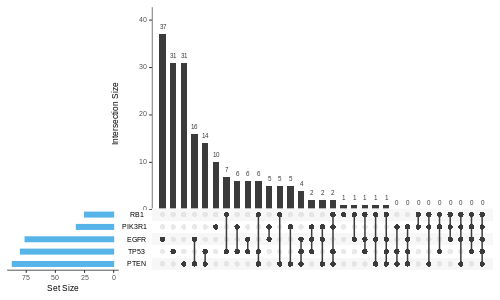

In [49]:
%%R -h 300 -w 500 -u px
upset(mutations, sets = c("PTEN", "TP53", "EGFR", "PIK3R1", "RB1"), sets.bar.color = "#56B4E9",
order.by = "freq", empty.intersections = "on")

Upset peak intersections

In [150]:
%%R
peak_intersections <- read.csv( "post_macs2_peak-calling_consensus.q.01.len250.consensus.intersections.UpSetR.csv", header=T, sep = ",")
head(peak_intersections, n=3)

  chrom   start     end UNION IRI1A IRI2A SHAM1A SHAM2A
1  chr1 3116592 3116795     1     0     0      0      1
2  chr1 3116795 3117536     1     0     0      1      1
3  chr1 3117536 3117640     1     0     0      1      0


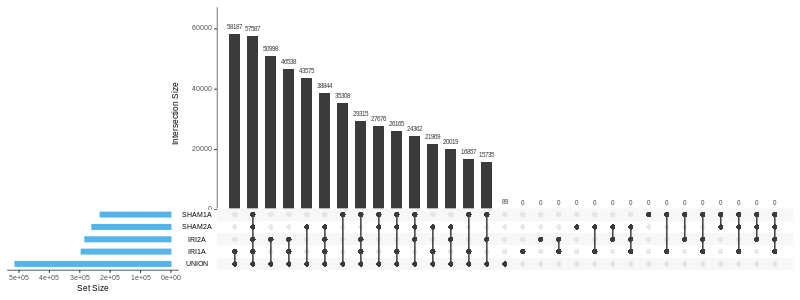

In [151]:
%%R  -h 300 -w 800 -u px
upset(peak_intersections, sets = c("UNION", "IRI1A", "IRI2A", "SHAM1A", "SHAM2A"), sets.bar.color = "#56B4E9",
order.by = "freq", empty.intersections = "on")

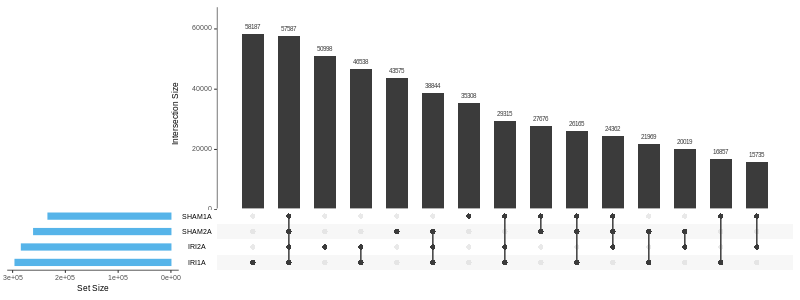

In [141]:
%%R  -h 300 -w 800 -u px
upset(peak_intersections, sets = c("IRI1A", "IRI2A", "SHAM1A", "SHAM2A"), sets.bar.color = "#56B4E9",
order.by = "freq", empty.intersections = "on")